# Quantum 2x2 Games

This notebook has been developed in order to formulate and analyze numerically the quantum versionof two canonical Game Theory problems: Prisoners' Dilemma and Battle of Sexes.

In [92]:
import numpy as np
import cmath
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import seaborn as sns
import warnings
import matplotlib.patches as mpatches


pd.set_option('display.max_rows', None)
sns.set_style("ticks")

The action space of a quantum 2x2 game is SU(2), i.e. the Hilbert space of unitary, trace-preserving 2x2 matrices.

A generic matrix in SU(2) can be written as a function of 2 parameters: <br>

$$
\hat{U}(\theta,\phi) = \begin{pmatrix}
e^{i\phi}\cos\theta/2 & \sin\theta/2 \\ -\sin\theta/2 & e^{-i\phi}\cos\theta/2
\end{pmatrix} \quad \theta\in[0,\pi], \phi\in[0,\frac{\pi}{2}] 
$$

and so it is possible to write a function that construct a generic quantum strategy accessible by one of the players.

In [4]:
def quantum_strategy(theta, phi):
    
    qs = np.zeros([2,2], dtype=complex)
    qs[0,0] = cmath.exp(1j*phi)*np.cos(theta/2)
    qs[0,1] = np.sin(theta/2)
    qs[1,0] = -np.sin(theta/2)
    qs[1,1] = cmath.exp(-1j*phi)*np.cos(theta/2)
    
    return qs

Also the original pure strategies for cooperating, C, and defecting, D, can be written in this way:

$$
\hat{C} = \hat{U}(0,0) = \begin{pmatrix}1&0\\0&1\end{pmatrix} \qquad
\hat{D} = \hat{U}(\pi,0) = \begin{pmatrix}0&1\\-1&0\end{pmatrix}
$$

In [5]:
C = quantum_strategy(0, 0)
D = quantum_strategy(np.pi, 0)

Usually, in these kind of games, each player has access to two pure strategies, C and D, and to the corresponding payoff bymatrix:

$$
\begin{pmatrix}
P_{CC,A},P_{CC,B} & P_{CD,A},P_{CD,B} \\ P_{DC,A},P_{DC,B} & P_{DD,A},P_{DD,B} \\
\end{pmatrix}
$$

The states of the (quantum) system are defined, as said, in SU(2), and are expressed as column vectors with four elements, written in the basis given by {|CC>, |CD>, |DC>, |DD>}, i.e. the computational basis (for example, |CC> corresponds to the vector (1,0,0,0), and so on).

In order to construct an effective quantum game, we need to provide also some kind of entanglement between the various states, and this will be possible introducing an operator that depends on a "entanglement measure"

$$
\hat{J} = \exp\left(-i\gamma\hat{D}\otimes\hat{D}/2\right) \qquad \gamma\in[0,\frac{\pi}{2}]
$$

such that the final state of the system, after the application of the actions chosen by the players, but before the effective measure of the qubits, will be given by:

$$
|\psi_f> = \hat{J}^\dagger\left(\hat{U}_A\otimes\hat{U}_B\right)\hat{J}|CC>
$$

In [6]:
def compute_final_state( strategyA, strategyB, gamma ):
    
    # Construct matrix J
    J = linalg.expm(-1j*gamma*np.kron(D,D)/2)
    # J^+ is just J's adjoint
    J1 = J.conjugate().transpose()
    # UA x UB is the kronecker product between the two quantum strategies
    UAB = np.kron(strategyA, strategyB)
    
    # Apply the operators one by one
    psi_f = np.matmul(J,np.array([1,0,0,0]))
    psi_f = np.matmul(UAB, psi_f)
    psi_f = np.matmul(J1, psi_f)
    
    return psi_f

In the end, since the only way to find the best set of strategies to follow is to check the payoff, the formula to compute the expected utility for player i is:

$$
<i> = P_{CC,i}\cdot|<CC|\psi_f>|^2 + P_{CD,i}\cdot|<CD|\psi_f>|^2 + P_{DC,i}\cdot|<DC|\psi_f>|^2 + P_{DD,i}\cdot|<DD|\psi_f>|^2
$$

In [7]:
def expected_payoffs( state, payoff_bymatrix ):
    
    payoffA, payoffB = 0, 0
    
    for i in range(2):
        for j in range(2):
            payoffA += payoff_bymatrix['A'][i,j]*(abs(state[2*i+j])**2)
            payoffB += payoff_bymatrix['B'][i,j]*(abs(state[2*i+j])**2)
    
    return [payoffA, payoffB]

Just to check the correctness of our code, we can rely on the fact that selecting $\gamma=0$ we should obtain the original classical game! <br>
So, if for example, we ask the two players to choose the joint strategy {DC}, then as final state we should get |DC> in the computational basis, that is (0,0,1,0).

In [8]:
warnings.filterwarnings('ignore')

compute_final_state( strategyA=D, strategyB=C, gamma=0 ).astype(int)

array([ 0,  0, -1,  0])

Note: the -  sign in the coefficient is irrelevant because what matters is its square module, i.e. $|-1|^2$, that represents the probability of finding the system in the state CD.

So everything seems working fine!

# Quantum Prisoners' Dilemma

The first problem that we are going to simulate as a quantum system is the traditional Prisoners' Dilemma.

In [9]:
# Specify the payoff matrix
payoff_matrix_pd = {'A' : np.array([[3,0],[5,1]]), 'B' : np.array([[3,5],[0,1]]) }

In [10]:
fs = compute_final_state( strategyA=D, strategyB=C, gamma=0 )

In [11]:
warnings.filterwarnings('ignore')

print("Example playing {DC}")
print("Final State:", list(map(int, fs)))
print("Expected payoffs:", list(map(int, expected_payoffs( fs, payoff_matrix_pd ))))

Example playing {DC}
Final State: [0, 0, -1, 0]
Expected payoffs: [5, 0]


It may be interesting, now, to analyze the different payoffs of player A in particular configurations. Then the game, at least for the moment, is symmetric, and so we are allowed to draw the same conclusions also for player B.

#### Separable case: $\gamma=0$

Let's set $\gamma=0$ and construct a discrete 4-dimensional grid for all the possible values of the parameters $\theta$ and $\phi$ for both players.

In [12]:
# Fix some default value for the parameters (proceed by multiple of np.pi)
grid_step_theta = np.pi/10
grid_step_phi = np.pi/20

thetaA = np.arange(0, np.pi+grid_step_theta, grid_step_theta)
phiA = np.arange(0, np.pi/2.+grid_step_phi, grid_step_phi)
thetaB = np.arange(0, np.pi+grid_step_theta, grid_step_theta)
phiB = np.arange(0, np.pi/2.+grid_step_phi, grid_step_phi)

In [13]:
# Define a function that construct a grid of values considering all the possible 
#combinations of the 4 parameters given in input

def payoff_grid(thetaA, phiA, thetaB, phiB, payoff_matrix, gamma, verbose):
    
    size = len(thetaA)*len(phiA)*len(thetaB)*len(phiB)
    grid = np.zeros(shape=(size,6))
    if(verbose): pbar = tqdm(total = size)
    s = 0

    for i in thetaA:
        for j in phiA:
            for k in thetaB:
                for l in phiB:
                    sA = quantum_strategy(i, j)
                    sB = quantum_strategy(k, l)
                    fs = compute_final_state(sA, sB, gamma)  
                    utility = expected_payoffs(fs, payoff_matrix)
                    grid[s] = [i, j, k, l, utility[0], utility[1]]
                    s += 1
                    if(verbose): pbar.update(1)
    
    # Construct a pandas DataFrame with the grid
    df = pd.DataFrame(grid, columns=["thetaA","phiA","thetaB","phiB","utilityA", "utilityB"])
    
    return df
                

The dimensionality of the problem is 5, and so is not so easy to plot a "utility function" directly. So, in order to find the maximum values we proceed numerically, showing only the most significant plots.

The best way to find numerically the Nash Equilibrium of the game is applying the definition, and looking for the joint strategy, i.e. a set $\{\theta_A, \phi_A, \theta_B, \phi_B\}$ that is a best response for both players to any other possible choice of the opponent.

In [14]:
def Is_Best_Response(grid, row, player):
    ''' Return true if strategy A/B is a best response to B/A '''
    
    if player == "A": opponent = "B"
    elif player == "B": opponent = "A"        
    
    util_p = "utility" + player
    th_o = "theta" + opponent
    ph_o = "phi" + opponent
        
    max_util_p = grid[(grid[th_o]==row[th_o]) & (grid[ph_o]==row[ph_o])].max()[util_p]
    
    # Return True if strategy of player is a best response to the strategy of the opponent
    
    if abs(row[util_p] - max_util_p)<1E-3: return True
    else: return False
          
           

def Nash_Equilibrium(thetaA, phiA, thetaB, phiB, payoff_matrix, gamma):
    
    # Construct the payoff grid
    print("Constructing the complete grid of payoffs...")
    grid = payoff_grid(thetaA, phiA, thetaB, phiB, payoff_matrix, gamma, True)
    
    grid["Best_responses_A"] = None
    grid["Best_responses_B"] = None
    
    # Collect all the best responses of player A to any strategy of B and viceversa
    print("Computing the best responses for the players...")
    for index, row in tqdm(grid.iterrows(),total=len(grid)):
        grid.loc[index, "Best_responses_A"] = Is_Best_Response(grid, row, "A")
        grid.loc[index, "Best_responses_B"] = Is_Best_Response(grid, row, "B")
    
    return grid


def Is_Pareto_Optimal(grid, joint_strategy_idx):
    
    # Verify if in the dataframe there is a strategy with better payoffs for both players
    util_A = grid.loc[joint_strategy_idx, "utilityA"]
    util_B = grid.loc[joint_strategy_idx, "utilityB"]
    
    pareto_opt = grid[(grid["utilityA"]>util_A) & (grid["utilityB"]>util_B)]
    
    if pareto_opt.empty: 
        print("The strategy is Pareto optimal!")
        return 
    else:
        print("The strategy is not Pareto optimal! ")
        print("Better alternatives:")
        display(pareto_opt)
        return 

In [15]:
brs_pd = Nash_Equilibrium(thetaA, phiA, thetaB, phiB, payoff_matrix_pd, 0)

# The joint strategies that are NE are simoultanoeus best responses
ne_qpd = brs_pd[brs_pd["Best_responses_A"] & brs_pd["Best_responses_B"]]

  2%|▏         | 297/14641 [00:00<00:04, 2961.17it/s]

Constructing the complete grid of payoffs...


  0%|          | 16/14641 [00:00<01:33, 156.46it/s]

Computing the best responses for the players...


100%|██████████| 14641/14641 [01:04<00:00, 227.81it/s]


Now we can show all the joint strategies that are Nash equilibria for $\gamma=0$.

In [16]:
pd.set_option('display.max_rows', None)
display(ne_qpd)

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B
13420,3.141593,0.000000,3.141593,0.000000,1.0,1.0,True,True
13421,3.141593,0.000000,3.141593,0.157080,1.0,1.0,True,True
13422,3.141593,0.000000,3.141593,0.314159,1.0,1.0,True,True
13423,3.141593,0.000000,3.141593,0.471239,1.0,1.0,True,True
13424,3.141593,0.000000,3.141593,0.628319,1.0,1.0,True,True
13425,3.141593,0.000000,3.141593,0.785398,1.0,1.0,True,True
13426,3.141593,0.000000,3.141593,0.942478,1.0,1.0,True,True
13427,3.141593,0.000000,3.141593,1.099557,1.0,1.0,True,True
13428,3.141593,0.000000,3.141593,1.256637,1.0,1.0,True,True
13429,3.141593,0.000000,3.141593,1.413717,1.0,1.0,True,True


Becuase of the limited numerical precision, is better now to look directly in the dataframe containing all the Nash equilibria, to avoid errors. <br>
The first thing we can notice is the fact that the parameters $\phi_A$ and $\phi_B$ seems to be ininfluent on the final payoff: the reason is that since $\gamma=0$, all the probabilities and the states of the two players are separable, and so all these complex phases vanishes when multiplying first by $\hat{J}$ and then by $\hat{J^\dagger}$. Another point of view can be found looking at the values of $\theta_A$ and $\theta_B$, that are all equal to $\pi$; then, remembering the form of the generic SU(2) strategy, all the contributes of $\phi$ vanishes when setting $\theta=\pi$. <br>
So, we are able to finally state that for $\gamma=0$, all the nash equilibrium strategies are of the type $\{\hat{U}(\pi,\phi_A),\hat{U}(\pi,\phi_B)\}$ and the corresponding utility values are $[1,1]$. <br>
Final thing to recall: $\hat{U}(\pi,\phi)$ is nothing but the old pure strategy of defection $\hat{D}$.

We can have further confirmations to this making additional analysis:

* we can give a look at the payoff of each player as functions of the parameters $\theta$ (since $\phi$, as we have seen, has no importance at the equilibrium);

In [17]:
grid_gamma0 = payoff_grid(thetaA, phiA, thetaB, phiB, payoff_matrix_pd, 0, True)

 98%|█████████▊| 14380/14641 [00:04<00:00, 3547.64it/s]

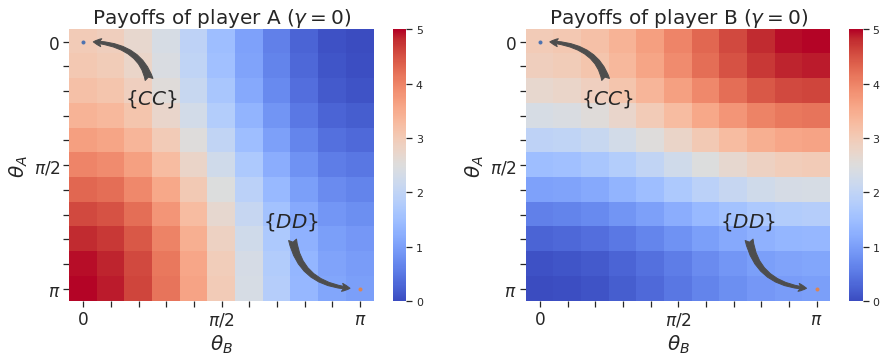

In [137]:
# Plot the results as a heatmap
fig, ax = plt.subplots(1,2,figsize=(15,5))
grid_gamma0_pivotA = grid_gamma0[(grid_gamma0["phiA"]==0) & (grid_gamma0["phiB"]==0)].pivot("thetaA", "thetaB", "utilityA")
grid_gamma0_pivotB = grid_gamma0[(grid_gamma0["phiA"]==0) & (grid_gamma0["phiB"]==0)].pivot("thetaA", "thetaB", "utilityB")

ticklabels = ['0'] + ['']*(len(thetaB)//2-1) + [r'$\pi$/2'] + ['']*(len(thetaB)//2-1) + [r'$\pi$']


pAgamma0 = sns.heatmap(grid_gamma0_pivotA, cmap="coolwarm", ax=ax[0])
pAgamma0.set_title(r'Payoffs of player A ($\gamma=0$)', fontsize=20)
pAgamma0.set_ylabel(r'$\theta_A$', fontsize = 20)
pAgamma0.set_xlabel(r'$\theta_B$', fontsize = 20)
pAgamma0.set_xticklabels(ticklabels, size = 17, rotation=0)
pAgamma0.set_yticklabels(ticklabels, size = 17)
pAgamma0.plot(0.5, 0.5, ".")
pAgamma0.annotate(r'$\{CC\}$', xy=(0.5, 0.5), fontsize=20, xytext=(2,3),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))
pAgamma0.plot(10.5, 10.5, ".")
pAgamma0.annotate(r'$\{DD\}$', xy=(10.5, 10.5), fontsize=20, xytext=(7,8),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))


pBgamma0 = sns.heatmap(grid_gamma0_pivotB, cmap="coolwarm", ax=ax[1]);
pBgamma0.set_title(r'Payoffs of player B ($\gamma=0$)', fontsize=20)
pBgamma0.set_ylabel(r'$\theta_A$', fontsize = 20)
pBgamma0.set_xlabel(r'$\theta_B$', fontsize = 20)
pBgamma0.set_xticklabels(ticklabels, size = 17, rotation=0)
pBgamma0.set_yticklabels(ticklabels, size = 17)
pBgamma0.plot(0.5, 0.5, ".")
pBgamma0.annotate(r'$\{CC\}$', xy=(0.5, 0.5), fontsize=20, xytext=(2,3),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))
pBgamma0.plot(10.5, 10.5, ".")
pBgamma0.annotate(r'$\{DD\}$', xy=(10.5, 10.5), fontsize=20, xytext=(7,8),
                  arrowprops=dict(arrowstyle="fancy", color="0.3", shrinkA=5, shrinkB=10, 
                                connectionstyle="angle3,angleA=90,angleB=0"))
plt.show()

As expected, if one player goes $\theta\to 0$ and the other goes $\theta\to\pi$ we are in the classical situations of joint strategies {CD} or {DC}, in which the utility is low for one and big for the other one, but this is not a NE. So for $\gamma=0$ the game is basically the same as in the classic world (in some sense we can make a correspondence between quantum strategies with $\theta=\pi$ and classical mixed strategies). If we look at the plots above, the NE strategy is not pareto optimal, and so the "dilemma" still holds.

* or we can instead analyze the minima payoff guaranteed to player A for any of his strategies, and then extending the results to player B by symmetry.

In [140]:
def guaranteed_payoffs(thetaA, phiA, thetaB, phiB, player, payoff_matrix, gamma):
    
    s = 0
    
    pbar = tqdm(total = len(thetaA)*len(phiA))

    if player == "A":
        
        min_utils = np.zeros(shape=(len(thetaA)*len(phiA), 3))
        
        for tA in thetaA:
            for pA in phiA:
                
                # Take the minimum payoff achievable if A plays U(tA, pA)
                min_uA = payoff_grid([tA], [pA], thetaB, phiB, payoff_matrix, gamma, False).min()["utilityA"]
                min_utils[s] = [tA, pA, min_uA]
                s+=1
                pbar.update(1)
                
    elif player == "B":
        
        min_utils = np.zeros(shape=(len(thetaB)*len(phiB), 3))
        
        for tB in thetaB:
            for pB in phiB:
                
                # Take the minimum payoff achievable if B plays U(tB, pB)
                min_uB = payoff_grid(thetaA, phiA, [tB], [pB], payoff_matrix, gamma, False).min()["utilityB"]
                min_utils[s] = [tB, pB, min_uB]
                s+=1
                pbar.update(1)
            
    return pd.DataFrame(min_utils, columns=("theta", "phi", "utility"))

In [141]:
min_payoffs_gamma0_A = guaranteed_payoffs(thetaA, phiA, thetaB, phiB, "A", payoff_matrix_pd, 0)

100%|██████████| 121/121 [00:04<00:00, 31.31it/s]

Text(7, 5.5, '$D$')

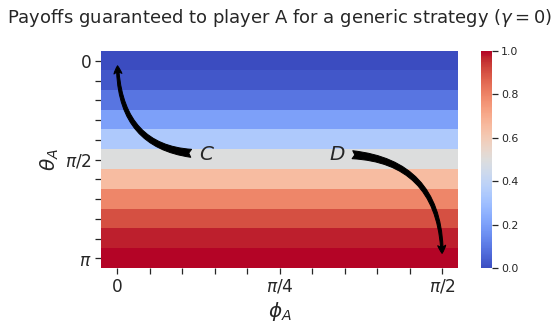

In [180]:
# Plot the results as a heatmap
fig = plt.figure(figsize=(8,4))
min_payoffs_gamma0_A_pivot = min_payoffs_gamma0_A.pivot("theta", "phi", "utility")

xticklabels = ['0'] + ['']*(len(phiA)//2-1) + [r'$\pi$/4'] + ['']*(len(phiA)//2-1) + [r'$\pi/2$']
yticklabels = ['0'] + ['']*(len(thetaA)//2-1) + [r'$\pi$/2'] + ['']*(len(thetaA)//2-1) + [r'$\pi$']

minpAgamma0 = sns.heatmap(min_payoffs_gamma0_A_pivot, cmap="coolwarm")

minpAgamma0.set_xticklabels(xticklabels, size = 17, rotation=0)
minpAgamma0.set_yticklabels(yticklabels, size = 17)
minpAgamma0.set_title(r'Payoffs guaranteed to player A for a generic strategy ($\gamma=0$)', fontsize=18, y=1.1)
minpAgamma0.set_xlabel(r'$\phi_A$', fontsize=20)
minpAgamma0.set_ylabel(r'$\theta_A$', fontsize=20)

minpAgamma0.annotate(r'$C$', xy=(0.5,0.5), fontsize=20, xytext=(3,5.5),
                  arrowprops=dict(arrowstyle="fancy", color="0", shrinkA=5, shrinkB=5,
                                 connectionstyle="angle3,angleA=0,angleB=90"))
minpAgamma0.annotate(r'$D$', xy=(10.5,10.5), fontsize=20, xytext=(7,5.5),
                  arrowprops=dict(arrowstyle="fancy", color="0", shrinkA=5, shrinkB=5,
                                 connectionstyle="angle3,angleA=0,angleB=90"))

Again we get something that we expected: the minimum payoff guaranteed to player A is between 0 (strategy {CD}) and 1 (at the NE). And the same results, for symmetry, hold for player B.

Analogy with classical game:if A decides to play $\hat{D}$ (for simplicity), his payoff is maximized regardless of the strategy chosen by player B. <br>
And since, as we said, the game is symmetric, we have found an equilibrium, i.e. $\hat{D}\otimes\hat{D}$, in dominant strategies.

Let's see if this NE, $\{\hat{D},\hat{D}\}$ is at least Pareto optimal:

In [32]:
# DD is the 13420th row in the grid
Is_Pareto_Optimal(grid_gamma0, 13420)

The strategy is not Pareto optimal! 
Better alternatives:


,thetaA,phiA,thetaB,phiB,utilityA,utilityB
0,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
1,0.000000,0.000000,0.000000,0.157080,3.000000,3.000000
2,0.000000,0.000000,0.000000,0.314159,3.000000,3.000000
3,0.000000,0.000000,0.000000,0.471239,3.000000,3.000000
4,0.000000,0.000000,0.000000,0.628319,3.000000,3.000000
5,0.000000,0.000000,0.000000,0.785398,3.000000,3.000000
6,0.000000,0.000000,0.000000,0.942478,3.000000,3.000000
7,0.000000,0.000000,0.000000,1.099557,3.000000,3.000000
8,0.000000,0.000000,0.000000,1.256637,3.000000,3.000000
9,0.000000,0.000000,0.000000,1.413717,3.000000,3.000000


It isn't, as in the classical game: the only strategy that is Pareto optimal is the mutual cooperation, that is not NE.

#### Maximally entangled case: $\gamma=\pi/2$

Then, using the same approach, we can analyze also the case in which the two players' states are maximally entangled. <br>
Let's fix $\gamma=\pi/2$.

In [21]:
brs_pd_me = Nash_Equilibrium(thetaA, phiA, thetaB, phiB, payoff_matrix_pd, np.pi/2)

# The joint strategies that are NE are simoultanoeus best responses
ne_qpd_me = brs_pd_me[brs_pd_me["Best_responses_A"] & brs_pd_me["Best_responses_B"]]

  2%|▏         | 239/14641 [00:00<00:06, 2387.76it/s]

Constructing the complete grid of payoffs...


  0%|          | 25/14641 [00:00<01:00, 242.09it/s]

Computing the best responses for the players...


100%|██████████| 14641/14641 [00:43<00:00, 337.32it/s]


In [22]:
display(ne_qpd_me)

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B
1220,0.0,1.570796,0.0,1.570796,3.0,3.0,True,True


Assuming player A goes $\hat{Q} = \hat{U}(0,\pi/2)$, what are the possible payoffs of B?

In [23]:
grid_me_AQ = payoff_grid([0], [np.pi/2], thetaB, phiB, payoff_matrix_pd, np.pi/2, True)

100%|██████████| 121/121 [00:00<00:00, 2259.33it/s]


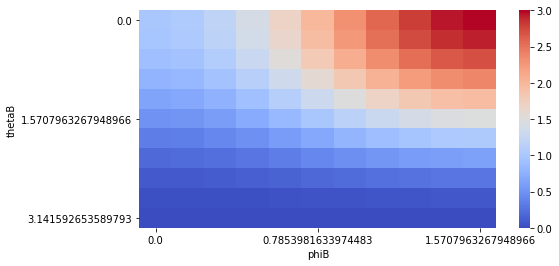

In [24]:
# Plot the results as a heatmap
fig = plt.figure(figsize=(8,4))

grid_me_AQ_pivot = grid_me_AQ.pivot("thetaB", "phiB", "utilityB")

ax = sns.heatmap(grid_me_AQ_pivot, xticklabels=5, yticklabels=5, cmap="coolwarm")

In [30]:
Is_Pareto_Optimal(brs_pd_me, 1220)

The strategy is Pareto optimal!


### Quantum player vs Classical opponent

Now suppose that only player A is allowed to select quantum strategies, while player B is limited to the classical world:
* A's strategies: $\hat{U}(\theta_A,\phi_A)$
* B's strategies: $\hat{U}(\theta_B,0)$

Does this situation provide any kind of advantage to one of the players?

Again, let's study the NE in the maimum entanglement case.

In [26]:
brs_pd_me_qc = Nash_Equilibrium(thetaA, phiA, thetaB, [0], payoff_matrix_pd, np.pi/2)

# The joint strategies that are NE are simoultanoeus best responses
ne_qpd_me_qc = brs_pd_me_qc[brs_pd_me_qc["Best_responses_A"] & brs_pd_me_qc["Best_responses_B"]]

 17%|█▋        | 232/1331 [00:00<00:00, 2314.83it/s]

Constructing the complete grid of payoffs...


  2%|▏         | 24/1331 [00:00<00:05, 236.82it/s]

Computing the best responses for the players...


100%|██████████| 1331/1331 [00:03<00:00, 379.47it/s]


In [27]:
display(ne_qpd_me_qc)

,thetaA,phiA,thetaB,phiB,utilityA,utilityB,Best_responses_A,Best_responses_B


There are no NE in this game, and the reason is that player A is in a strong position respect to player B. It possible to prove, in fact, that there exists a strategy $\hat{M}$ avaiable to A (a "miracle move") that guarantees to him always the maximum payoff:
$$ \hat{M}\equiv\hat{U}(\pi/2,\pi/2)=\frac{1}{\sqrt{2}}\begin{pmatrix} i&-1\\1&-i \end{pmatrix}  $$
To prove it, we can directly look at the utility heatmaps in that case.

In [85]:
payoffs_QvsC = payoff_grid([np.pi/2], [np.pi/2], thetaB, [0], payoff_matrix_pd, np.pi/2, True)




100%|██████████| 11/11 [00:00<00:00, 1043.22it/s]


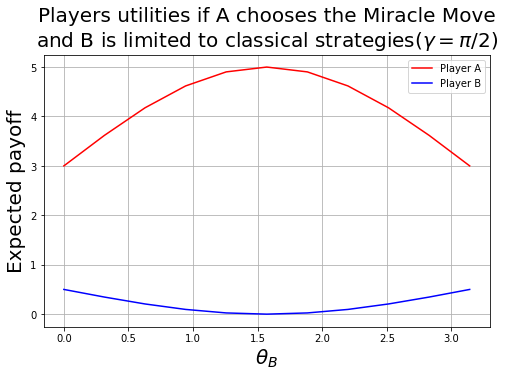

In [89]:
fig = plt.figure(figsize=(8,5))

plt.title("Players utilities if A chooses the Miracle Move\nand B is limited to classical strategies" 
          + r'($\gamma=\pi/2$)', fontsize=20, y=1.01)
plt.xlabel(r'$\theta_B$', fontsize=20)
plt.ylabel("Expected payoff", fontsize=20)
plt.plot(payoffs_QvsC["thetaB"], payoffs_QvsC["utilityA"], color="red", label="Player A")
plt.plot(payoffs_QvsC["thetaB"], payoffs_QvsC["utilityB"], color="blue", label="Player B")
plt.grid()
plt.legend();

Finally, we can make a comparison between the three "particular" strategies that A can select ($\hat{C}$, $\hat{D}$ or $\hat{M}$), as a function of the classical one chosen by the opponent.

In [95]:
util_AC = payoff_grid([0], [0], thetaB, [0], payoff_matrix_pd, np.pi/2, True)["utilityA"]
util_AD = payoff_grid([np.pi], [0], thetaB, [0], payoff_matrix_pd, np.pi/2, True)["utilityA"]
util_AM = payoff_grid([np.pi/2], [np.pi/2], thetaB, [0], payoff_matrix_pd, np.pi/2, True)["utilityA"]




100%|██████████| 11/11 [00:00<00:00, 1146.98it/s]



100%|██████████| 11/11 [00:00<00:00, 1620.90it/s]



100%|██████████| 11/11 [00:00<00:00, 1809.73it/s]


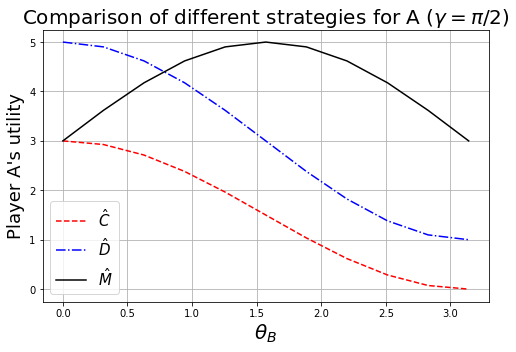

In [117]:
fig = plt.figure(figsize=(8,5))
plt.title(r'Comparison of different strategies for A ($\gamma=\pi/2$)', fontsize=20)
plt.xlabel(r'$\theta_B$', fontsize=20)
plt.ylabel("Player A's utility", fontsize=18)

plt.plot(thetaB, util_AC, label=r'$\hat{C}$', color="red", linestyle="dashed")
plt.plot(thetaB, util_AD, label=r'$\hat{D}$', color="blue", linestyle="dashdot")
plt.plot(thetaB, util_AM, label=r'$\hat{M}$', color="black", linestyle="solid")
plt.grid()
plt.legend(fontsize=15);

#### Payoffs at intermediate entaglement degrees

One last interesting analysis that can be done is looking at what happen when $\gamma$ goes from $0$ to $\pi$.

Let's evaluate

In [130]:
gamma_values = np.arange(0, np.pi/2*1.1, np.pi/20)
maximin_A = []

for g in gamma_values:
    maximin_A.append(guaranteed_payoffs(thetaA, phiA, thetaB, [0], "A", payoff_matrix_pd, g).max()["utility"])




  0%|          | 0/121 [00:00<?, ?it/s]


 17%|█▋        | 20/121 [00:00<00:00, 199.25it/s]


 34%|███▍      | 41/121 [00:00<00:00, 200.97it/s]


 54%|█████▎    | 65/121 [00:00<00:00, 211.21it/s]


 74%|███████▍  | 90/121 [00:00<00:00, 219.04it/s]


 93%|█████████▎| 113/121 [00:00<00:00, 219.70it/s]



  0%|          | 0/121 [00:00<?, ?it/s]



 17%|█▋        | 20/121 [00:00<00:00, 196.29it/s]



 39%|███▉      | 47/121 [00:00<00:00, 213.23it/s]



 61%|██████    | 74/121 [00:00<00:00, 225.93it/s]



100%|██████████| 121/121 [00:00<00:00, 249.52it/s]




  0%|          | 0/121 [00:00<?, ?it/s]



 19%|█▉        | 23/121 [00:00<00:00, 225.36it/s]



 38%|███▊      | 46/121 [00:00<00:00, 224.97it/s]



 55%|█████▌    | 67/121 [00:00<00:00, 217.86it/s]



 74%|███████▎  | 89/121 [00:00<00:00, 216.80it/s]



100%|██████████| 121/121 [00:00<00:00, 221.92it/s]




  0%|          | 0/121 [00:00<?, ?it/s]



 19%|█▉        | 23/121 [00:00<00:00, 226.94it/s]



 38%|███▊      | 46/121 [00:00

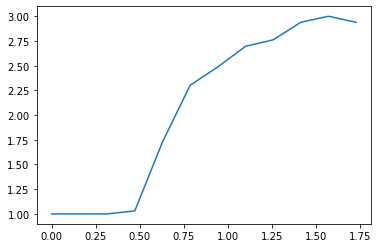

In [131]:
plt.plot(gamma_values, maximin_A)